In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

from scipy.linalg import orth
from numpy.linalg import eig
from numpy.linalg import svd

%matplotlib inline

In [2]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

First, let's simulate some data to work with...   

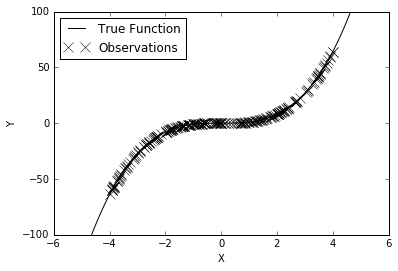

In [3]:
# Simulate N observations from a cubic function
N = 250
x = np.array([np.random.uniform(-4,4) for n in range(N)])[np.newaxis].T
y = x**3

# True function
N_true = 100
x_true = np.linspace(start=-6, stop=6, num=N_true)
y_true = x_true**3

plt.plot(x_true, y_true, 'k-', label="True Function")
plt.plot(x, y, 'xk', ms=10, linewidth=1, label="Observations")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

## Distilling Neural Networks into Local Linear Regressors
#### by [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/) 

Neural network distillation [(Ba and Caruana, 2013)](https://arxiv.org/abs/1312.6184) [(Hinton et al., 2015)](https://arxiv.org/abs/1503.02531) [(Balan et al., 2015)](http://papers.nips.cc/paper/5965-bayesian-dark-knowledge)---where the probabilities produced by a large 'teacher' model are used as targets for training a smaller 'student' model---is crucial for delopying neural networks to systems for which runtime and memory are limited.  This notebook proposes a new strategy for *probabilistic* distillation, providing a distribution over various simpler models.  Moreover, the proposed method has the benefits that (1) the student model does not need its own optimization loop and (2) as the students are mixtures of linear models, they allow for a high degree of interpretability.    

### 1.  Nonparametric Regression
We first review [nonparametric regression](http://www.stat.cmu.edu/~larry/=sml/nonpar.pdf) methods.  Recall kernelized nearest neighbors regression, which for an input $\mathbf{x}$ has the form: $$ \mathbb{E}[\mathbf{y} | \mathbf{x}] \ \ = \ \ \boldsymbol{\mu}^{Y} \ \ = \ \ \sum_{i=1}^{N} \pi_{i}(\mathbf{x}) \ \mathbf{y}_{i}  \ \ \ \text{where} \ \ \ \pi_{i}(\mathbf{x}) = \frac{k(\mathbf{x}, \mathbf{x}_{i}; \beta)}{\sum_{j=1}^{N} k(\mathbf{x}, \mathbf{x}_{j}; \beta)}.$$  $\boldsymbol{\mu}^{Y}$ is the mean of the label/reponse distribution, $\pi_{i}(\mathbf{x})$ is a weighting function comprised of kernels, and $\beta$ is a scale parameter for the kernels.     

In [4]:
def kernel(x1, x2, beta=.1):
    #if x1[0] == x2[0]: return 1.
    #return 0
    return np.exp(-np.sum((x1-x2)**2)/beta)


kernel_vals = np.zeros((N_true, N))
beta_val = .1

for i in range(N_true):
    for j in range(N):
        kernel_vals[i,j] = kernel(x_true[i], x[j], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

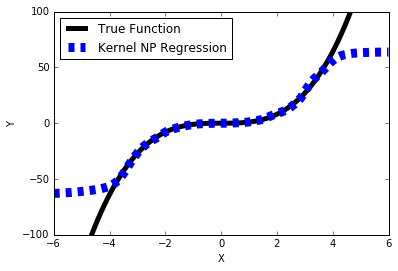

In [5]:
yHat_kernelNN = np.sum(y.T * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, yHat_kernelNN, 'b--', linewidth=9, label="Kernel NP Regression")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

### 2.  Transforming Neural Networks into Local Regressors
Next consider the problem of compressing a trained feedforward neural network with ReLU activations.  Define the network as $\boldsymbol{\mu}^{Y}_{i} = g^{-1}(f(\mathbf{x}_{i}; \boldsymbol{\theta}))$ where $\boldsymbol{\mu}^{Y}_{i}$ is the mean of the output distribution for input $\mathbf{x}_{i}$, $g(\cdot)$ is the link function, and $f(\mathbf{x}_{i}; \boldsymbol{\theta})$ is the output of the neural network (before the output activation).

#### 0th Order Approximation
One, possibly naive, idea is to use the predicted outputs within the nearest neighbors regression framework: $$ g(\boldsymbol{\mu}^{Y, 0}) \ \ = \ \ \sum_{i=1}^{N} \pi_{i}(\mathbf{x}) \ g(\hat{\mathbf{y}}_{i}) \ \ = \ \ \sum_{i=1}^{N} \pi_{i}(\mathbf{x}) \ f(\mathbf{x}_{i}; \boldsymbol{\theta})$$ where $\hat{\mathbf{y}}_{i} = g^{-1}(f(\mathbf{x}_{i}; \boldsymbol{\theta}))$.  Notice that we have changed the formulation slightly, having the weighted sum being taken over the sufficient statistic (pre-link).  This approach doesn't make much sense, however, since it would be much easier to use the observed labels than training another model and using the predicted ones---although, the model may introduce some regularity / smoothing.

#### 1st Order Approximation
Yet, we can improve the approximation by incorportaing more information about the function the network learned.  For a test point $\mathbf{x}$, we can make its corresponding prediction by examining a first-order Taylor expansion around training point $\mathbf{x}_{i}$: $ f(\mathbf{x}; \boldsymbol{\theta}) \approx f(\mathbf{x}_{i}; \boldsymbol{\theta}) + (\mathbf{x} - \mathbf{x}_{i}) \frac{\partial f(\mathbf{x}_{i}; \boldsymbol{\theta})}{\partial \mathbf{x}_{i}}.$  The resulting local regression model is then:  $$ g(\boldsymbol{\mu}^{Y, 1}) \ \ = \ \ \sum_{i=1}^{N} \pi_{i}(\mathbf{x}) \ [f(\mathbf{x}_{i}; \boldsymbol{\theta}) + (\mathbf{x} - \mathbf{x}_{i}) \frac{\partial f(\mathbf{x}_{i}; \boldsymbol{\theta})}{\partial \mathbf{x}_{i}}].$$  However, as pointed out by [Wang et al. (ICML 2016)](http://proceedings.mlr.press/v48/wanga16.pdf),  feedforward ReLU networks have a special property: $f(\mathbf{x}_{i}; \boldsymbol{\theta}) = \mathbf{x}_{i} \frac{\partial f(\mathbf{x}_{i}; \boldsymbol{\theta})}{\partial \mathbf{x}_{i}}$, and thus we can simplify to: $$ g(\boldsymbol{\mu}^{Y, 1}) \ \ = \ \ \sum_{i=1}^{N} \pi_{i}(\mathbf{x}) \ [f(\mathbf{x}_{i}; \boldsymbol{\theta}) + \mathbf{x} \frac{\partial f(\mathbf{x}_{i}; \boldsymbol{\theta})}{\partial \mathbf{x}_{i}} - \mathbf{x}_{i} \frac{\partial f(\mathbf{x}_{i}; \boldsymbol{\theta})}{\partial \mathbf{x}_{i}}] \ \ = \ \ \sum_{i=1}^{N} \pi_{i}(\mathbf{x}) \ \mathbf{x} \frac{\partial f(\mathbf{x}_{i}; \boldsymbol{\theta})}{\partial \mathbf{x}_{i}} .$$  As we can precompute these first derivatives, storing them as vectors $\frac{\partial f(\mathbf{x}_{i}; \boldsymbol{\theta})}{\partial \mathbf{x}_{i}} = \mathbf{u}_{i}$, we have reduced the ReLU network to locally linear functions.  This result isn't too surprising, as it is known that [ReLU networks are piecewise linear](https://arxiv.org/abs/1611.01491). 

#### 2nd Order Approximation
One may then ask, can we further increase the accuracy of the Taylor approximation.  The answer is 'no,' as $\frac{\partial^{2} f(\mathbf{x}_{i}; \boldsymbol{\theta})}{\partial \mathbf{x}^{2}_{i}} = 0$.  Thus, the first-order approximation is *locally* exact.

####  Experiment: Regression Simulation

Let's now demonstrate how to find the mixture of experts representation a network trained on one-dimensional data...

Next let's define the model: a one-hidden-layer neural network with 50 units...

In [6]:
# Regression NN with one hidden layer of 50 units
def logModel(W, b, x, y):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    y_hat = np.dot(h, W[:, 50:].T) + b[:, 50:]
    return np.sum( .5 * -(y - y_hat)**2 )

def fprop(W, b, x):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    return np.dot(h, W[:, 50:].T) + b[:, 50:]


### GET DERIVATIVES ###
# d log p(X | \theta) / d \theta
dLogModel_dW = grad(logModel)
dLogModel_db = grad(lambda b, W, x, y: logModel(W, b, x, y))

Now let's train the NN...

In [7]:
### INIT PARAMS 
theta = {'W': .001 * np.random.normal(size=(1,100)), 'b': np.zeros((1,51))}

### ELBO OPTIMIZATION
maxEpochs = 1000
learning_rate = .01
adam_values = {'W':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

loss = 0.
for epochIdx in range(maxEpochs):
    
    dModel_dW = dLogModel_dW(theta['W'], theta['b'], x, y) 
    dModel_db = dLogModel_db(theta['b'], theta['W'], x, y)
        
    theta['W'] += get_AdaM_update(learning_rate, dModel_dW, adam_values['W'])  
    theta['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b'])
    
    loss += logModel(theta['W'], theta['b'], x, y)
    if (epochIdx+1) % 100 == 0:
        print "%d. Neg. Log Likelihood: %.3f" %(epochIdx+1, -loss/5.)
        loss = 0.

100. Neg. Log Likelihood: 866698.480
200. Neg. Log Likelihood: 335568.926
300. Neg. Log Likelihood: 211118.111
400. Neg. Log Likelihood: 110159.146
500. Neg. Log Likelihood: 53508.606
600. Neg. Log Likelihood: 30123.812
700. Neg. Log Likelihood: 21552.774
800. Neg. Log Likelihood: 18166.713
900. Neg. Log Likelihood: 12711.086
1000. Neg. Log Likelihood: 8042.307


And visualize the results...

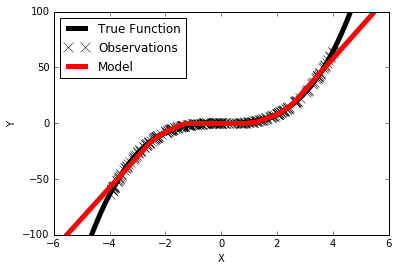

In [8]:
plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x, y, 'xk', ms=10, linewidth=1, label="Observations")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=5, label="Model")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### Linearizing the Network

Next let's write a function that extracts $\tilde{\mathbf{U}}_{i}$ for each $\mathbf{x}_{i}$...

In [9]:
def get_linear_transform(x_i, W, b):
    #copy
    W_tilde = np.array(W)
    b_tilde = np.array(b)
    
    # fprop
    h = np.maximum(np.dot(x_i, W[:, :50]) + b[:, :50], 0.)
    
    # apply mask
    for j in range(50):
        if h[0, j] == 0: 
            W_tilde[:, j] = 0.
            b_tilde[:, j] = 0.
            
    # construct matrices
    W1_tilde = np.vstack([W_tilde[:, :50], b_tilde[:, :50]]) #add bias
    next_bias = np.hstack([1./x_i, np.zeros((1,1))]).T
    W1_tilde = np.hstack([W1_tilde, next_bias]) # add bias for next layer
    
    W2_tilde = np.vstack([W_tilde[:, 50:].T, b_tilde[:, 50:]]) #add bias
    
    return np.dot(W1_tilde, W2_tilde)

Next we calculate all the $\tilde{\mathbf{U}}$ vectors...

In [10]:
x = np.sort(x, axis=0)

U_vectors = []
for i in range(N):
    U_vectors.append( get_linear_transform(x[i,:][np.newaxis], theta['W'], theta['b'])[:,0] )
U_vectors = np.array(U_vectors).T

Define a kernel function and calculate it between all pairs...

In [11]:
def kernel(x1, x2, beta=.1):
    #if x1[0] == x2[0]: return 1.
    #return 0
    return np.exp(-np.sum((x1-x2)**2)/beta)

kernel_vals = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        kernel_vals[i,j] = kernel(x[i], x[j])
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

#### Training Data Result

Visualize the result on the training data..

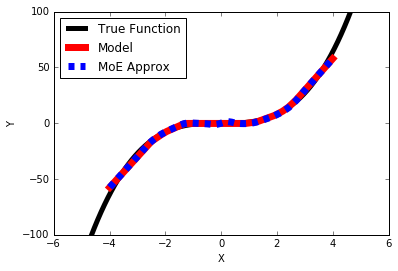

In [12]:
x_w_bias = np.hstack([x, np.ones((N,1))])
yHat_MoE = np.sum(np.dot(x_w_bias, U_vectors) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x, fprop(theta['W'], theta['b'], x), 'r-', linewidth=7, label="Model")
plt.plot(x, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### Test Data Result

Visualize the result for the true function...

In [13]:
kernel_vals = np.zeros((100, N))
beta_val = .1

for i in range(100):
    for j in range(N):
        kernel_vals[i,j] = kernel(x_true[i], x[j], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

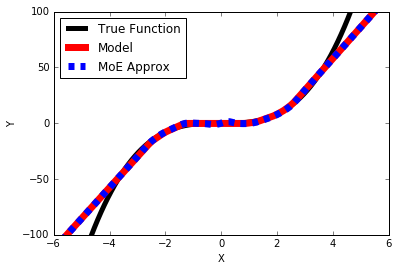

In [14]:
xTrue_w_bias = np.hstack([x_true[np.newaxis].T, np.ones((100,1))])
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_vectors) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

### 2.  Pruning Experts 
Using the above mixture of experts representation in place of the original model requires $\mathcal{O}(Nd)$ time, as it depends on the number of training points, which is a dependence we'd like to break.  Hence, we would like form a good approximation using only a subset of the experts: $$ f(\mathbf{x}; \{ \tilde{\mathbf{U}}_{1}, \tilde{\mathbf{U}}_{2}, \ldots, \tilde{\mathbf{U}}_{N} \}) \  \approx  \  \sum_{k=1}^{K} \pi_{k}(\mathbf{x}) \ \mathbf{x}  \tilde{\mathbf{U}}_{k}$$ for $K<<N$.  How should we choose the subset?  Below we attempt several different strategies...

#### A.  Random Sampling
We start with a naive solution: random sampling.  We sample $K$ pairs $\{\mathbf{x}_{k}, \tilde{\mathbf{U}}_{k} \}$ without replacement from the set of $N$.     

In [15]:
K = 4
k_idxs = np.random.choice(N, K)

kernel_vals = np.zeros((100, K))
beta_val = 1.

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

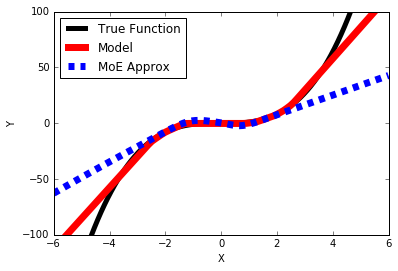

In [16]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### B.  Regular Sampling
We continue with another naive solution: sampling regular interval.  We sample $K$ pairs $\{\mathbf{x}_{k}, \tilde{\mathbf{U}}_{k} \}$ by choosing every $N/k$th ordered point.     

In [17]:
K = 4
k_idxs = [0] + [k * N/(K-1) for k in range(1, K-1)] + [N-1]
print k_idxs

kernel_vals = np.zeros((100, K))

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

[0, 83, 166, 249]


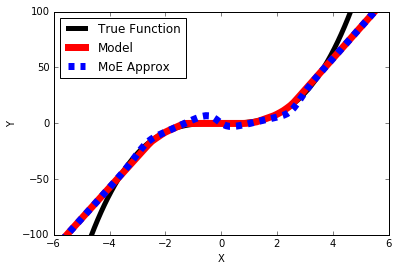

In [18]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### C.   Douglas-Peucker Algorithm
For polylines, there is a recursive simplification algorithm known as the [Douglas-Peucker Algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm).  It has an expected runtime of $\mathcal{O}(N \log N)$.     

In [19]:
import math
import time


def timenow():
    return int(time.time() * 1000)

def sqr(x):
    return x*x

def distSquared(p1, p2):
    return sqr(p1[0] - p2[0]) + sqr(p1[1] - p2[1])

class Line(object):
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        self.lengthSquared = distSquared(self.p1, self.p2)

    def getRatio(self, point):
        segmentLength = self.lengthSquared
        if segmentLength == 0:
            return distSquared(point, p1);
        return ((point[0] - self.p1[0]) * (self.p2[0] - self.p1[0]) + \
        (point[1] - self.p1[1]) * (self.p2[1] - self.p1[1])) / segmentLength

    def distanceToSquared(self, point):
        t = self.getRatio(point)

        if t < 0:
            return distSquared(point, self.p1)
        if t > 1:
            return distSquared(point, self.p2)

        return distSquared(point, [
            self.p1[0] + t * (self.p2[0] - self.p1[0]),
            self.p1[1] + t * (self.p2[1] - self.p1[1])
        ])

    def distanceTo(self, point):
        return math.sqrt(self.distanceToSquared(point))


def simplifyDouglasPeucker(points, pointsToKeep):
    weights = []
    length = len(points)

    def douglasPeucker(start, end):
        if (end > start + 1):
            line = Line(points[start], points[end])
            maxDist = -1
            maxDistIndex = 0

            for i in range(start + 1, end):
                dist = line.distanceToSquared(points[i])
                if dist > maxDist:
                    maxDist = dist
                    maxDistIndex = i

            weights.insert(maxDistIndex, maxDist)

            douglasPeucker(start, maxDistIndex)
            douglasPeucker(maxDistIndex, end)

    douglasPeucker(0, length - 1)
    weights.insert(0, float("inf"))
    weights.append(float("inf"))

    weightsDescending = weights
    weightsDescending = sorted(weightsDescending, reverse=True)

    maxTolerance = weightsDescending[pointsToKeep - 1]
    result = [
        point for i, point in enumerate(points) if weights[i] >= maxTolerance
    ]

    return result

In [20]:
K = 4
point_tups = zip(x[:,0].tolist(), fprop(theta['W'], theta['b'], x)[:,0].tolist())
points_kept = simplifyDouglasPeucker(points=point_tups, pointsToKeep=K)
k_idxs = [point_tups.index(p) for p in points_kept]

kernel_vals = np.zeros((100, K))

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

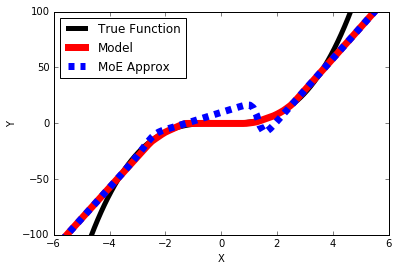

In [21]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### D.   Sensitivity-Based Pruning
Recall that $\tilde{\mathbf{U}}_{i} = \frac{\partial g(\boldsymbol{\mu}^{Y}_{i})}{\partial \mathbf{x}_{i}}$, and therefore  $|| \tilde{\mathbf{U}}_{i}|| = || \frac{\partial g(\boldsymbol{\mu}^{Y}_{i})}{\partial \mathbf{x}_{i}} ||$.  In other words, the linear transformations with the largest norms are the ones most sensitive to the input $\mathbf{x}$, changing their output quickly with small changes to the input.  It is reasonable to think that these transformations have the least chance of generalizing and therefore should be the ones that are pruned.  In classification settings, we may prune for each class separately.

In [22]:
K = 8
k_idxs = ((np.sum(U_vectors**2, axis=0))).argsort()[N/2-K/2:-(N/2-K/2)]
print k_idxs

kernel_vals = np.zeros((100, K))

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

[140 188 189 190 191 192 193 194]


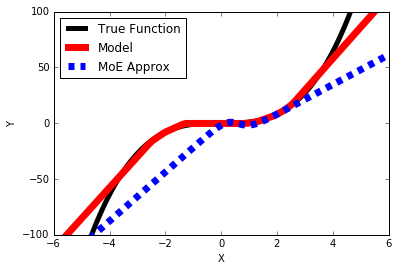

In [23]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### E.   Low-Rank Representation
Instead of pruning $\tilde{\mathbf{U}}_{i}$'s, we can simply try to find a low-rank representation that takes all transformations into account: $\tilde{\mathbf{U}}_{d \times N} = \mathbf{V}_{d \times K} \mathbf{Q}_{K \times N}$.  The $\mathbf{V}$ matrix can then be used to make predictions.  If $\tilde{\mathbf{U}}_{i}$ is a matrix, then we must perform tensor decomposition.  In order to formulate the kernel weighting function, we'll need to change the basis of the original dataset via $\mathbf{Q}\mathbf{X} = \mathbf{Z}_{K \times d}$

In [24]:
K=2
V,S,Q = svd(U_vectors, full_matrices=False)
S = np.diag(S)
Z_train = np.dot(Q, x)  # K X d

kernel_vals = np.zeros((100, K))
k_idxs = [0, 1]
for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], Z_train[k], 1.)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

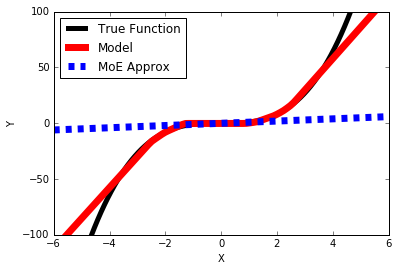

In [25]:
yHat_MoE = np.sum(np.dot(xTrue_w_bias, V) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

### 3.  Experiment: MNIST
We now test the above pruning strategy on a more realistic example, MNIST.  Let's load the data...

In [26]:
from sklearn.datasets import fetch_mldata
from random import shuffle

mnist = fetch_mldata('MNIST original')

# reduce dataset and normalize to [0,1]
random_idxs = range(mnist.data.shape[0])
shuffle(random_idxs)
train_x = mnist.data[random_idxs[:10000],:] / 255.
test_x = mnist.data[random_idxs[10000:15000],:] / 255.
train_y = np.zeros((10000, 10))
for i, y in enumerate(mnist.target[random_idxs[:10000]]):
    train_y[i, int(y)] = 1.
test_y = mnist.target[random_idxs[10000:15000]].tolist()

In [27]:
N, input_d = train_x.shape
N_test = test_x.shape[0]
hidden_d = 250
n_classes = train_y.shape[1]

def softmax(z):
    y = np.exp(z)
    return y / y.sum()

# Classification NN with one hidden layer
def fprop(W, b, x):
    h = np.maximum(np.dot(x, W[:, :input_d * hidden_d].reshape(input_d, hidden_d)) + b[:, :hidden_d], 0.)
    return np.dot(h, W[:, input_d * hidden_d:].reshape(hidden_d, n_classes)) + b[:, hidden_d:]

def logModel(W, b, x, y):
    y_hat = softmax(fprop(W, b, x))
    return np.mean( y * np.log(y_hat) )

def accuracy(y, y_hat):    
    correct = 0.
    for y, yh in zip(y, y_hat): 
        if y == yh: correct += 1
    return correct / len(y_hat)


### GET DERIVATIVES ###
# d log p(X | \theta) / d \theta
dLogModel_dW = grad(logModel)
dLogModel_db = grad(lambda b, W, x, y: logModel(W, b, x, y))

In [28]:
### INIT PARAMS 
theta = {'W': .001 * np.random.normal(size=(1, input_d*hidden_d + hidden_d*n_classes)), 'b': np.zeros((1, hidden_d + n_classes))}

### ELBO OPTIMIZATION
maxEpochs = 50
batchSize = 100
learning_rate = .0003
adam_values = {'W':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

loss = 0.
for epochIdx in range(maxEpochs):
    
    for batchIdx in range(10000/batchSize):
    
        dModel_dW = dLogModel_dW(theta['W'], theta['b'], train_x[batchIdx*batchSize:(batchIdx+1)*batchSize, :], train_y[batchIdx*batchSize:(batchIdx+1)*batchSize, :]) 
        dModel_db = dLogModel_db(theta['b'], theta['W'], train_x[batchIdx*batchSize:(batchIdx+1)*batchSize, :], train_y[batchIdx*batchSize:(batchIdx+1)*batchSize, :])
        
        theta['W'] += get_AdaM_update(learning_rate, dModel_dW, adam_values['W'])  
        theta['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b'])
    
    loss += logModel(theta['W'], theta['b'], train_x, train_y)
    if (epochIdx+1) % 3 == 0:
        print "%d. Neg. Log Likelihood: %.3f" %(epochIdx+1, -loss/3.)
        loss = 0.

3. Neg. Log Likelihood: 1.007
6. Neg. Log Likelihood: 0.973
9. Neg. Log Likelihood: 0.961
12. Neg. Log Likelihood: 0.953
15. Neg. Log Likelihood: 0.948
18. Neg. Log Likelihood: 0.944
21. Neg. Log Likelihood: 0.941
24. Neg. Log Likelihood: 0.939
27. Neg. Log Likelihood: 0.937
30. Neg. Log Likelihood: 0.935
33. Neg. Log Likelihood: 0.934
36. Neg. Log Likelihood: 0.932
39. Neg. Log Likelihood: 0.931
42. Neg. Log Likelihood: 0.930
45. Neg. Log Likelihood: 0.929
48. Neg. Log Likelihood: 0.928


In [29]:
og_net_train_acc = accuracy(np.argmax(train_y, axis=1).tolist(), np.argmax(softmax(fprop(theta['W'], theta['b'], train_x)), axis=1).tolist())
og_net_test_acc = accuracy(test_y, np.argmax(softmax(fprop(theta['W'], theta['b'], test_x)), axis=1).tolist())

print "Train accuracy: %.4f" %(og_net_train_acc)
print "Test accuracy: %.4f" %(og_net_test_acc)

Train accuracy: 0.9939
Test accuracy: 0.9580


In [30]:
def get_linear_transform(x_i, W, b):
    #copy
    W1_tilde = np.array(W[:, :input_d * hidden_d].reshape(input_d, hidden_d))
    W2 = np.array(W[:, input_d * hidden_d:].reshape(hidden_d, n_classes))
    b_tilde = np.array(b)
    
    # fprop
    h = np.maximum(np.dot(x_i, W1_tilde) + b_tilde[:, :hidden_d], 0.)
    
    # apply mask
    for j in range(hidden_d):
        if h[0, j] == 0: 
            W1_tilde[:, j] = np.zeros((input_d))
            b_tilde[:, j] = 0.
            
    # construct matrices
    W1_tilde = np.vstack([W1_tilde, b_tilde[:, :hidden_d]]) #add bias
    next_bias = np.hstack([np.ones((1, input_d))/x_i.sum(), np.zeros((1,1))]).T 
    W1_tilde = np.hstack([W1_tilde, next_bias]) # add bias for next layer
    
    W2_tilde = np.vstack([W2, b_tilde[:, hidden_d:]]) #add bias
    
    return np.dot(W1_tilde, W2_tilde)

In [31]:
U_vectors = []
for i in range(N):
    U_vectors.append( get_linear_transform(train_x[i,:][np.newaxis], theta['W'], theta['b']) )

In [32]:
train_x_w_bias = np.hstack([train_x, np.ones((N,1))])
test_x_w_bias = np.hstack([test_x, np.ones((N_test,1))])
Ks = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
n_reruns = 10

all_train = np.zeros((n_reruns, len(Ks)))
all_test = np.zeros((n_reruns, len(Ks)))
all_train_knn = np.zeros((n_reruns, len(Ks)))
all_test_knn = np.zeros((n_reruns, len(Ks)))
all_train_fo = np.zeros((n_reruns, len(Ks)))
all_test_fo = np.zeros((n_reruns, len(Ks)))

for run_idx in range(n_reruns):
    
    print "running #%d..." %(run_idx)
    
    for idx_k, K in enumerate(Ks):
        k_idxs = []
        train_labels = np.argmax(train_y, axis=1).tolist()
        counter = np.ones((n_classes,)) * K
        for k, val in enumerate(train_labels):
            if counter[val] > 0: 
                k_idxs.append(k)
                counter[val] -= 1
            if counter.sum() == 0: break

        beta_val = 5.
        #train_kernel_vals = np.zeros((N, K*n_classes))
        test_kernel_vals = np.zeros((N_test, K*n_classes))

        #for i in range(N):
        #    for j,k in enumerate(k_idxs):
        #        train_kernel_vals[i,j] = kernel(train_x[i], train_x[k], beta_val)
                
        for i in range(N_test):
            for j,k in enumerate(k_idxs):
                test_kernel_vals[i,j] = kernel(test_x[i], train_x[k], beta_val)
        
        #train_kernel_vals = train_kernel_vals / (train_kernel_vals.sum(axis=1)[np.newaxis].T)
        test_kernel_vals = test_kernel_vals / (test_kernel_vals.sum(axis=1)[np.newaxis].T)
    
        U_subset = [U_vectors[k] for k in k_idxs]

        temp1 = 0.
        temp2 = 0.
        temp3 = 0.
        temp4 = 0.
        temp5 = 0.
        for k, U in enumerate(U_subset):
            #temp1 += np.dot(train_x_w_bias, U) * train_kernel_vals[:,k][np.newaxis].T
            temp2 += np.dot(test_x_w_bias, U) * test_kernel_vals[:,k][np.newaxis].T
        
        #temp3 = np.dot(train_y[k_idxs, :].T, train_kernel_vals.T).T
        temp4 = np.dot(train_y[k_idxs, :].T, test_kernel_vals.T).T
        #temp5 = softmax(np.dot(fprop(theta['W'], theta['b'], train_x[k_idxs,:]).T, train_kernel_vals.T).T)
        temp6 = softmax(np.dot(fprop(theta['W'], theta['b'], train_x[k_idxs,:]).T, test_kernel_vals.T).T)

        #train_yHat_MoE = softmax(temp1)
        test_yHat_MoE = softmax(temp2)

        #moe_train_acc = accuracy(np.argmax(train_y, axis=1).tolist(), np.argmax(train_yHat_MoE, axis=1).tolist())
        moe_test_acc = accuracy(test_y, np.argmax(test_yHat_MoE, axis=1).tolist())
        #knn_train_acc = accuracy(np.argmax(train_y, axis=1).tolist(), np.argmax(temp3, axis=1).tolist())
        knn_test_acc = accuracy(test_y, np.argmax(temp4, axis=1).tolist())
        #fo_train_acc = accuracy(np.argmax(train_y, axis=1).tolist(), np.argmax(temp5, axis=1).tolist())
        fo_test_acc = accuracy(test_y, np.argmax(temp6, axis=1).tolist())

        #print "MoE: Train accuracy for K=%d: %.4f" %(K, moe_train_acc)
        #print "MoE: Test accuracy for K=%d: %.4f" %(K, moe_test_acc)
        #print "KNN: Train accuracy for K=%d: %.4f" %(K, knn_train_acc)
        #print "KNN: Test accuracy for K=%d: %.4f" %(K, knn_test_acc)
        #print "FO: Train accuracy for K=%d: %.4f" %(K, fo_train_acc)
        #print "FO: Test accuracy for K=%d: %.4f" %(K, fo_test_acc)
        #print
    
        #all_train.append(moe_train_acc)
        all_test[run_idx, idx_k] = moe_test_acc
        #all_train_knn.append(knn_train_acc)
        all_test_knn[run_idx, idx_k] = knn_test_acc
        #all_train_fo.append(fo_train_acc)
        all_test_fo[run_idx, idx_k] = fo_test_acc

running #0...
running #1...
running #2...
running #3...
running #4...
running #5...
running #6...
running #7...
running #8...
running #9...


In [34]:
### LINEAR MODEL BASELINE ###
# Classification NN with one hidden layer
def fprop_linear(W, b, x):
    return softmax(np.dot(x, W.reshape(input_d, n_classes)) + b)

def logModel_linear(W, b, x, y):
    y_hat = fprop_linear(W, b, x)
    return np.mean( y * np.log(y_hat) )


### GET DERIVATIVES ###
# d log p(X | \theta) / d \theta
dLogModel_linear_dW = grad(logModel_linear)
dLogModel_linear_db = grad(lambda b, W, x, y: logModel_linear(W, b, x, y))

### INIT PARAMS 
theta = {'W': .001 * np.random.normal(size=(1, input_d*n_classes)), 'b': np.zeros((1, n_classes))}

### ELBO OPTIMIZATION
maxEpochs = 100
batchSize = 100
learning_rate = .0003
adam_values = {'W':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

loss = 0.
for epochIdx in range(maxEpochs):
    
    for batchIdx in range(10000/batchSize):
    
        dModel_dW = dLogModel_linear_dW(theta['W'], theta['b'], train_x[batchIdx*batchSize:(batchIdx+1)*batchSize, :], train_y[batchIdx*batchSize:(batchIdx+1)*batchSize, :]) 
        dModel_db = dLogModel_linear_db(theta['b'], theta['W'], train_x[batchIdx*batchSize:(batchIdx+1)*batchSize, :], train_y[batchIdx*batchSize:(batchIdx+1)*batchSize, :])
        
        theta['W'] += get_AdaM_update(learning_rate, dModel_dW, adam_values['W'])  
        theta['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b'])
    
    loss += logModel_linear(theta['W'], theta['b'], train_x, train_y)
    if (epochIdx+1) % 3 == 0:
        print "%d. Neg. Log Likelihood: %.3f" %(epochIdx+1, -loss/3.)
        loss = 0.
        
baseline_train_acc = accuracy(np.argmax(train_y, axis=1).tolist(), np.argmax(fprop_linear(theta['W'], theta['b'], train_x), axis=1).tolist())
baseline_test_acc = accuracy(test_y, np.argmax(fprop_linear(theta['W'], theta['b'], test_x), axis=1).tolist())

print
print "Train accuracy: %.4f" %(baseline_train_acc)
print "Test accuracy: %.4f" %(baseline_test_acc)

3. Neg. Log Likelihood: 1.035
6. Neg. Log Likelihood: 1.001
9. Neg. Log Likelihood: 0.991
12. Neg. Log Likelihood: 0.986
15. Neg. Log Likelihood: 0.983
18. Neg. Log Likelihood: 0.981
21. Neg. Log Likelihood: 0.979
24. Neg. Log Likelihood: 0.978
27. Neg. Log Likelihood: 0.977
30. Neg. Log Likelihood: 0.976
33. Neg. Log Likelihood: 0.975
36. Neg. Log Likelihood: 0.975
39. Neg. Log Likelihood: 0.974
42. Neg. Log Likelihood: 0.973
45. Neg. Log Likelihood: 0.973
48. Neg. Log Likelihood: 0.973
51. Neg. Log Likelihood: 0.972
54. Neg. Log Likelihood: 0.972
57. Neg. Log Likelihood: 0.971
60. Neg. Log Likelihood: 0.971
63. Neg. Log Likelihood: 0.971
66. Neg. Log Likelihood: 0.970
69. Neg. Log Likelihood: 0.970
72. Neg. Log Likelihood: 0.970
75. Neg. Log Likelihood: 0.970
78. Neg. Log Likelihood: 0.969
81. Neg. Log Likelihood: 0.969
84. Neg. Log Likelihood: 0.969
87. Neg. Log Likelihood: 0.969
90. Neg. Log Likelihood: 0.969
93. Neg. Log Likelihood: 0.969
96. Neg. Log Likelihood: 0.968
99. Neg. Lo

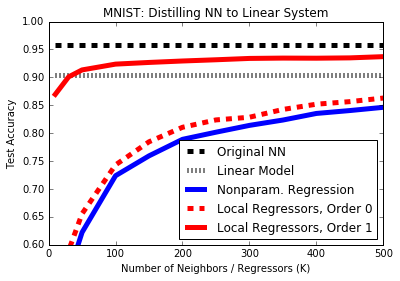

In [40]:
all_test_mean = all_test.mean(axis=0)
all_test_stds = all_test.std(axis=0)

all_test_knn_mean = all_test_knn.mean(axis=0)
all_test_knn_stds = all_test_knn.std(axis=0)

all_test_fo_mean = all_test_fo.mean(axis=0)
all_test_fo_stds =  all_test_fo.std(axis=0)

#plt.plot([k*10 for k in Ks], [og_net_train_acc]*len(Ks), 'b--', linewidth=5, label="Original NN, Train")
plt.plot([k*10 for k in Ks], [og_net_test_acc]*len(Ks), 'k--', linewidth=5, label="Original NN")

#plt.plot([k*10 for k in Ks], [baseline_train_acc]*len(Ks), 'b:', linewidth=5, label="Linear Model, Train")
plt.plot([k*10 for k in Ks], [baseline_test_acc]*len(Ks), 'k:', linewidth=5, label="Linear Model")

plt.fill_between([k*10 for k in Ks], all_test_knn_mean - 3*all_test_knn_std, all_test_knn_mean + 3*all_test_knn_stds, interpolate=True, color='blue', alpha=.80)
plt.plot([k*10 for k in Ks], all_test_knn_mean, 'b-', linewidth=5, label="Nonparam. Regression")

#plt.plot([k*10 for k in Ks], all_train_knn, 'c-', linewidth=5, label="Local Regressors, Order 0, Train")
plt.fill_between([k*10 for k in Ks], all_test_knn_mean - 3*all_test_knn_std, all_test_knn_mean + 3*all_test_knn_stds, interpolate=True, color='blue', alpha=.80)
plt.plot([k*10 for k in Ks], all_test_fo_mean, 'r--', linewidth=5, label="Local Regressors, Order 0")

#plt.plot([k*10 for k in Ks], all_train, 'b-', linewidth=5, label="Local Regressors, Order 1, Train")
plt.fill_between([k*10 for k in Ks], all_test_mean - 3*all_test_std, all_test_mean + 3*all_test_knn_stds, interpolate=True, color='blue', alpha=.80)
plt.plot([k*10 for k in Ks], all_test_mean, 'r-', linewidth=5, label="Local Regressors, Order 1")

plt.xlabel("Number of Neighbors / Regressors (K)")
plt.ylabel("Test Accuracy")
plt.ylim([.6, 1])

plt.title("MNIST: Distilling NN to Linear System")
plt.legend(loc=4)
plt.show()

### 4.  Experiment: Pruning via DPP Sampling
Next, let's test how DPP sampling performs in comparison to uniform sampling...

In [41]:
y_hats_for_kernel = np.zeros((10, train_x_w_bias.shape[0], 10))
counters = np.zeros((10,))
y_list = np.argmax(train_y, axis=1).tolist()
for idx, U in enumerate(U_vectors):
    y_hats_for_kernel[y_list[idx], :, :] += np.dot(train_x_w_bias, U)
    counters[y_list[idx]] += 1

for idx in range(10):
    y_hats_for_kernel[idx, :, :] /= counters[idx]

In [48]:
from dpp_functions import *
import cPickle as cp

#vec_list = []
#val_list = []
#for i in range(n_classes):
#    gram_mat = np.dot(y_hats_for_kernel[i,:,:], y_hats_for_kernel[i,:,:].T)
#    vals, vecs = eig(gram_mat)
#    vec_list.append(vecs)
#    val_list.append(vals)

val_list, vec_list = cp.load(open("mnist_10k_kernel_decomp.pkl","rb"))

In [49]:
all_train_dpp = []
all_test_dpp = []
all_train_dpp = np.zeros((n_reruns, len(Ks)))
all_test_dpp = np.zeros((n_reruns, len(Ks)))

for run_idx in range(n_reruns):
    
    print "running #%d..." %(run_idx)
    
    for idx_k, K in enumerate(Ks):

        k_idxs = []
        for idx in range(n_classes):
            k_idxs += sample_from_dpp_preDecomp(val_list[idx], vec_list[idx], k=K)

        beta_val = 5.
        test_kernel_vals = np.zeros((N_test, K*n_classes))
    
        for i in range(N_test):
            for j,k in enumerate(k_idxs):
                test_kernel_vals[i,j] = kernel(test_x[i], train_x[k], beta_val)
            
        test_kernel_vals = test_kernel_vals / (test_kernel_vals.sum(axis=1)[np.newaxis].T)
        U_subset = [U_vectors[k] for k in k_idxs]

        temp1 = 0.
        for k, U in enumerate(U_subset):
            temp1 += np.dot(test_x_w_bias, U) * test_kernel_vals[:,k][np.newaxis].T

        test_yHat_dpp = softmax(temp1)

        dpp_test_acc = accuracy(test_y, np.argmax(test_yHat_dpp, axis=1).tolist())
    
        print "DPP: Test accuracy for K=%d: %.4f" %(K, dpp_test_acc)
        print
    
        all_test[run_idx, idx_k] = dpp_test_acc
    

running #0...


dpp_functions.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i,j] = E[i, j-1] + vals[j-1] * E[i-1, j-1]


DPP: Test accuracy for K=1: 0.8738

DPP: Test accuracy for K=3: 0.9146

DPP: Test accuracy for K=5: 0.9156

DPP: Test accuracy for K=10: 0.9246

DPP: Test accuracy for K=15: 0.9298

DPP: Test accuracy for K=20: 0.9282

DPP: Test accuracy for K=25: 0.9274

DPP: Test accuracy for K=30: 0.9320

DPP: Test accuracy for K=35: 0.9340

DPP: Test accuracy for K=40: 0.9298

DPP: Test accuracy for K=45: 0.9338



dpp_functions.py:34: RuntimeWarning: invalid value encountered in cdouble_scalars
  marg = vals[i-1] * E[remaining-1, i-1] / E[remaining, i];
dpp_functions.py:34: RuntimeWarning: overflow encountered in cdouble_scalars
  marg = vals[i-1] * E[remaining-1, i-1] / E[remaining, i];


DPP: Test accuracy for K=50: 0.9332

running #1...
DPP: Test accuracy for K=1: 0.8836

DPP: Test accuracy for K=3: 0.9058

DPP: Test accuracy for K=5: 0.9012

DPP: Test accuracy for K=10: 0.9220

DPP: Test accuracy for K=15: 0.9252

DPP: Test accuracy for K=20: 0.9298

DPP: Test accuracy for K=25: 0.9342

DPP: Test accuracy for K=30: 0.9360

DPP: Test accuracy for K=35: 0.9290

DPP: Test accuracy for K=40: 0.9342

DPP: Test accuracy for K=45: 0.9322

DPP: Test accuracy for K=50: 0.9342

running #2...
DPP: Test accuracy for K=1: 0.8376

DPP: Test accuracy for K=3: 0.9104

DPP: Test accuracy for K=5: 0.9078

DPP: Test accuracy for K=10: 0.9246

DPP: Test accuracy for K=15: 0.9272

DPP: Test accuracy for K=20: 0.9258

DPP: Test accuracy for K=25: 0.9356

DPP: Test accuracy for K=30: 0.9268

DPP: Test accuracy for K=35: 0.9296

DPP: Test accuracy for K=40: 0.9350

DPP: Test accuracy for K=45: 0.9346

DPP: Test accuracy for K=50: 0.9326

running #3...
DPP: Test accuracy for K=1: 0.8830

DPP

KeyboardInterrupt: 

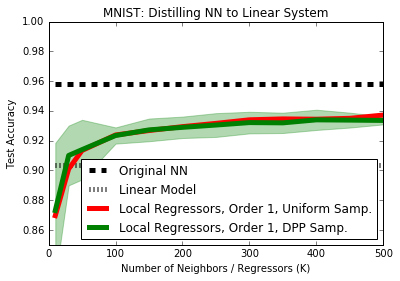

In [53]:
dpp_test_acc_temp = all_test[:9,:].mean(axis=0) #[.8656, .9110, .9108, .9252, .9238, .9306, .9280, .9322, .9310, .9306, .9350, .9350]
dpp_test_std = all_test[:9, :].std(axis=0)

#plt.plot([k*10 for k in Ks], [og_net_train_acc]*len(Ks), 'b--', linewidth=5, label="Original NN, Train")
plt.plot([k*10 for k in Ks], [og_net_test_acc]*len(Ks), 'k--', linewidth=5, label="Original NN")

#plt.plot([k*10 for k in Ks], [baseline_train_acc]*len(Ks), 'b:', linewidth=5, label="Linear Model, Train")
plt.plot([k*10 for k in Ks], [baseline_test_acc]*len(Ks), 'k:', linewidth=5, label="Linear Model")

#plt.plot([k*10 for k in Ks], all_test_knn, 'b-', linewidth=5, label="Nonparam. Regression")

#plt.plot([k*10 for k in Ks], all_train_knn, 'c-', linewidth=5, label="Local Regressors, Order 0, Train")
#plt.plot([k*10 for k in Ks], all_test_fo, 'r--', linewidth=5, label="Local Regressors, Order 0")

#plt.plot([k*10 for k in Ks], all_train, 'b-', linewidth=5, label="Local Regressors, Order 1, Train")
#plt.plot([k*10 for k in Ks], all_test, 'r-', linewidth=5, label="Local Regressors, Order 1, Uniform Samp.")

plt.fill_between([k*10 for k in Ks], all_test_mean - 3*all_test_std, all_test_mean + 3*all_test_stds, interpolate=True, color='red', alpha=.50)
plt.plot([k*10 for k in Ks], all_test_mean, 'r-', linewidth=5, label="Local Regressors, Order 1, Uniform Samp.")

plt.fill_between([k*10 for k in Ks], dpp_test_acc_temp - 3*dpp_test_std, dpp_test_acc_temp + 3*dpp_test_std, interpolate=True, color='green', alpha=.30)
plt.plot([k*10 for k in Ks], dpp_test_acc_temp, 'g-', linewidth=5, label="Local Regressors, Order 1, DPP Samp.")

plt.xlabel("Number of Neighbors / Regressors (K)")
plt.ylabel("Test Accuracy")
plt.ylim([.85, 1])

plt.title("MNIST: Distilling NN to Linear System")
plt.legend(loc=4)
plt.show()